<a href="https://colab.research.google.com/github/Ana-Ibarra/OpenClassroomProject/blob/Pretrained/P6_class_images_dogs_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import History 
from keras.callbacks import ModelCheckpoint, EarlyStopping
history = History()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fpath = "/content/drive/My Drive/OC_P6_images/images_squared_split/"
random_seed = 42
squared_size = 299
batch_size = 64
categories = os.listdir(fpath+"train")
print("List of categories = ", categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['n02087046-toy_terrier', 'n02085782-Japanese_spaniel', 'n02086079-Pekinese', 'n02086646-Blenheim_spaniel', 'n02086240-Shih-Tzu', 'n02085620-Chihuahua', 'n02088094-Afghan_hound', 'n02087394-Rhodesian_ridgeback', 'n02085936-Maltese_dog', 'n02086910-papillon', 'n02088238-basset', 'n02088466-bloodhound', 'n02088364-beagle', 'n02088632-bluetick', 'n02089867-Walker_hound', 'n02089078-black-and-tan_coonhound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091244-Ibizan_hound', 'n02091032-Italian_greyhound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091134-whippet', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093428-American_Staffordshire_terrier', 'n02093256-Staffordshire_bullterrier', 'n02093647-Bedlington_terrier', 'n02093859-Kerry_blue_terrier', 'n02093754-Border_terrier', 'n02094258-Norwich_terrier', 'n02094114-Norfolk_terrier', 'n02093991-Irish_terrier', 

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(fpath+"train",
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(squared_size, squared_size),
    shuffle=True,
    seed=1,
    validation_split=0.25,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)

Found 16501 files belonging to 120 classes.
Using 12376 files for training.


In [ ]:
len(train_ds)

194

In [ ]:
val_ds = keras.preprocessing.image_dataset_from_directory(fpath+"train",
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(squared_size, squared_size),
    shuffle=True,
    seed=1,
    validation_split=0.25,
    subset="validation",
    interpolation="bilinear",
    follow_links=False)

Found 16501 files belonging to 120 classes.
Using 4125 files for validation.


In [ ]:
test_ds = keras.preprocessing.image_dataset_from_directory(fpath+"test",
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(squared_size, squared_size),
    shuffle=True,
    seed=1,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

Found 4080 files belonging to 120 classes.


In [ ]:
class_names = train_ds.class_names
print("No of classes in Training dataset: ", len(class_names))
class_names = val_ds.class_names
print("No of classes in Validation dataset: ", len(class_names))
class_names = test_ds.class_names
print("No of classes in Test dataset: ", len(class_names))

No of classes in Training dataset:  120
No of classes in Validation dataset:  120
No of classes in Test dataset:  120


In [ ]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
        [layers.experimental.preprocessing.RandomFlip("horizontal"),
         layers.experimental.preprocessing.RandomRotation(0.1)])

Xception Model is proposed by Francois Chollet. Xception is an extension of the inception Architecture which replaces the standard Inception modules with depthwise Separable Convolutions.

In [ ]:
base_model = keras.applications.Xception(
             weights="imagenet", 
             input_shape=(squared_size, squared_size, 3),
             include_top=False)
# Freeze the base_model
base_model.trainable = False
# base_model.summary()

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
# Create new model on top

inputs = keras.Input(shape=(squared_size, squared_size, 3))
# Preprocess for input images as xception base model
x = keras.applications.xception.preprocess_input(inputs)
# Apply random data augmentation
# x = data_augmentation(x)   
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation= "relu")(x)
# Regularize with dropout
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense(len(categories),activation="softmax")(x)
xception_model = keras.Model(inputs, outputs)
xception_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0     

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the xception model: ", len(xception_model.layers))
print(len(base_model.trainable_variables))
print(len(xception_model.trainable_variables))

Number of layers in the base model:  132
Number of layers in the xception model:  8
0
4


In [ ]:
xception_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

In [ ]:
initial_epochs = 10

checkpoint_filepath = "/content/drive/My Drive/OC_P6_images/saved_models/weights.best.xception.hdf5"

callbacks_list = [
  ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=5, verbose=0)]

In [ ]:
%%time
history = xception_model.fit(train_ds, validation_data = val_ds, epochs=initial_epochs, callbacks=[callbacks_list])

Epoch 1/10
194/194 [==============================] - 4292s 21s/step - loss: 1.6513 - accuracy: 0.6583 - val_loss: 0.4822 - val_accuracy: 0.8548

Epoch 00001: val_accuracy improved from -inf to 0.85479, saving model to /content/drive/My Drive/OC_P6_images/saved_models/weights.best.xception.hdf5
Epoch 2/10
194/194 [==============================] - 173s 887ms/step - loss: 0.4053 - accuracy: 0.8759 - val_loss: 0.4486 - val_accuracy: 0.8647

Epoch 00002: val_accuracy improved from 0.85479 to 0.86473, saving model to /content/drive/My Drive/OC_P6_images/saved_models/weights.best.xception.hdf5
Epoch 3/10
194/194 [==============================] - 173s 886ms/step - loss: 0.3075 - accuracy: 0.9018 - val_loss: 0.4441 - val_accuracy: 0.8667

Epoch 00003: val_accuracy improved from 0.86473 to 0.86667, saving model to /content/drive/My Drive/OC_P6_images/saved_models/weights.best.xception.hdf5
Epoch 4/10
194/194 [==============================] - 173s 884ms/step - loss: 0.2396 - accuracy: 0.9193 

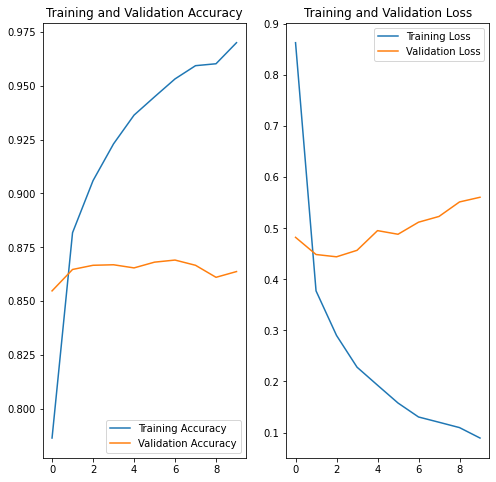

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=len(acc)
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

At this point we have the pre-train weights of the base model and the trained weight of the new/added top model
We re-load model weights to ensure the best epoch is selected and not the last one.
    

In [ ]:
# Load the Model with the Best Validation Loss
xception_model.load_weights('/content/drive/My Drive/OC_P6_images/saved_models/weights.best.xception.hdf5')

In [ ]:
xception_loss, xception_accuracy = xception_model.evaluate(test_ds)
print(xception_loss, xception_accuracy)

64/64 [==============================] - 42s 637ms/step - loss: 0.5393 - accuracy: 0.8569
0.5392599701881409 0.8568627238273621


"fine_tune" points to the layer in your model you want to train.
Layers before this number will used the pre-trained weights, layers above and including this number will be re-trained based on the new data.
    

In [ ]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune = 127
for layer in base_model.layers[:fine_tune]:
    layer.trainable =  False

In [ ]:
xception_model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

In [ ]:
print("Number of layers: ", len(base_model.layers))
print("Number of layers: ", len(xception_model.layers))
print(len(base_model.trainable_variables))
print(len(xception_model.trainable_variables))

Number of layers:  132
Number of layers:  8
6
10


In [ ]:
fine_tune_epochs = 10

# save weights of best training epoch
final_weights_filepath = "/content/drive/My Drive/OC_P6_images/saved_models/xception.weights.hdf5"
callbacks_list = [
        ModelCheckpoint(final_weights_filepath, monitor='val_accuracy', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    ]

In [ ]:
%%time
history_fine = xception_model.fit(train_ds, validation_data = val_ds, epochs=fine_tune_epochs, callbacks=[callbacks_list])

Epoch 1/10
194/194 [==============================] - 182s 919ms/step - loss: 0.1167 - accuracy: 0.9641 - val_loss: 0.4522 - val_accuracy: 0.8824

Epoch 00001: val_accuracy improved from -inf to 0.88242, saving model to /content/drive/My Drive/OC_P6_images/saved_models/xception.weights.hdf5
Epoch 2/10
194/194 [==============================] - 181s 924ms/step - loss: 0.0820 - accuracy: 0.9751 - val_loss: 0.4459 - val_accuracy: 0.8824

Epoch 00002: val_accuracy did not improve from 0.88242
Epoch 3/10
194/194 [==============================] - 181s 925ms/step - loss: 0.0718 - accuracy: 0.9785 - val_loss: 0.4478 - val_accuracy: 0.8817

Epoch 00003: val_accuracy did not improve from 0.88242
Epoch 4/10
194/194 [==============================] - 181s 924ms/step - loss: 0.0682 - accuracy: 0.9803 - val_loss: 0.4514 - val_accuracy: 0.8827

Epoch 00004: val_accuracy improved from 0.88242 to 0.88267, saving model to /content/drive/My Drive/OC_P6_images/saved_models/xception.weights.hdf5
Epoch 5/1

In [ ]:
# Load the Model with the Best Validation Loss
xception_model.load_weights('/content/drive/My Drive/OC_P6_images/saved_models/xception.weights.hdf5')

In [ ]:
xception_loss, xception_accuracy = xception_model.evaluate(test_ds)
print(xception_loss, xception_accuracy)

64/64 [==============================] - 43s 650ms/step - loss: 0.4904 - accuracy: 0.8730
0.4904208481311798 0.873039186000824


In [ ]:
xception_model.compile(optimizer=keras.optimizers.Adam(1e-7),  # Low learning rate
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

In [ ]:
fine_tune_epochs = 20
callbacks_list = [
        ModelCheckpoint(final_weights_filepath, monitor='val_accuracy', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=10, verbose=0)]

In [ ]:
%%time
history_fine = xception_model.fit(train_ds, validation_data = val_ds, epochs=fine_tune_epochs, callbacks=[callbacks_list])

Epoch 1/20
194/194 [==============================] - 183s 927ms/step - loss: 0.0596 - accuracy: 0.9811 - val_loss: 0.4545 - val_accuracy: 0.8846

Epoch 00001: val_accuracy improved from -inf to 0.88461, saving model to /content/drive/My Drive/OC_P6_images/saved_models/xception.weights.hdf5
Epoch 2/20
194/194 [==============================] - 181s 925ms/step - loss: 0.0565 - accuracy: 0.9832 - val_loss: 0.4545 - val_accuracy: 0.8846

Epoch 00002: val_accuracy did not improve from 0.88461
Epoch 3/20
194/194 [==============================] - 181s 925ms/step - loss: 0.0575 - accuracy: 0.9824 - val_loss: 0.4545 - val_accuracy: 0.8846

Epoch 00003: val_accuracy did not improve from 0.88461
Epoch 4/20
194/194 [==============================] - 181s 925ms/step - loss: 0.0593 - accuracy: 0.9808 - val_loss: 0.4545 - val_accuracy: 0.8846

Epoch 00004: val_accuracy did not improve from 0.88461
Epoch 5/20
 29/194 [===>..........................] - ETA: 1:56 - loss: 0.0583 - accuracy: 0.9844

In [ ]:
# Load the Model with the Best Validation Loss
xception_model.load_weights('/content/drive/My Drive/OC_P6_images/saved_models/xception.weights.hdf5')

In [ ]:
xception_loss, xception_accuracy = xception_model.evaluate(test_ds)
print(xception_loss, xception_accuracy)

64/64 [==============================] - 43s 650ms/step - loss: 0.4822 - accuracy: 0.8728
0.4821702539920807 0.8727940917015076


In [ ]:
model_json = xception_model.to_json()
with open(os.path.join("/content/drive/My Drive/OC_P6_images/saved_models/", 'model.json'), 'w') as json_file:
        json_file.write(model_json)

In [ ]:
# from pathlib import Path

# # Save neural network structure
# model_structure = xception_model.to_json()
# f = Path("model_structure.json")
# f.write_text(model_structure)

76289

In [ ]:
# # Index of predicted dog breed for each image in test set
# xception_predictions = [np.argmax(xception_model.predict(np.expand_dims(images, axis=0))) for feature in test_ds]

# # Test accuracy
# test_accuracy = 100*np.sum(np.array(xception_predictions)==np.argmax(labels, axis=1))/len(xception_predictions)
# print('Test accuracy: %.2f%%' % test_accuracy)

In [ ]:
keras.backend.clear_session()